<font size=4 color='blue'>

# <center> Clase 13-2, enero 13, 2021 </center>

<font size=5 color="blue">

Transferencia de estilo entre imágenes utilizando una red neuronal VGG-19
$ $
<font size=4 color='black'> 
    
[Referencia: A Neural Algorithm of Artistic Style](./literature/A-Neural-Algorithm-of-Artistic-Style.pdf)

#### <img src="https://drive.google.com/uc?id=1FqiRwUUQ52_xBnIcP1ANxVZABTSt9UaS" width=620 height=420 align = "center" >

<font size=4 color='black'>
    
[Tutorial de Keras sobre transferencia de estilo](https://keras.io/examples/generative/neural_style_transfer/)

<font size=5 color='blue'>
Aplicaciones

<font size=4 color='black'> 
    
[Referencia: Detection of Wearing of Masks](./literature/vgg19_applications/detection-wearing-masks_2020.pdf)

<font size=4 color='black'> 
    
[Referencia: Fundus_Image classification](./literature/vgg19_applications/Fundus_image-classification_2018.pdf)

<font size=4 color='black'> 
    
[Referencia: Fault Diagnosis](./literature/vgg19_applications/fault_diagnosis_2019.pdf)

<font size=4 color='black'> 
    
[Referencia: Smart-Phone Based Waste Classification](./literature/vgg19_applications/waste-classification_2020.pdf)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [ ]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



<font size=5 color='blue'>
    
Imágen a modificar y la que tiene el estilo a transferir

```Python
#This is an alternative way to get images from URLs

#Imagen base
base_image_path = keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
print(type(base_image_path))
#Imagen de estilo
style_reference_image_path = keras.utils.get_file("starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
```

In [ ]:
#Imagen base
base_image_path = "./images/Green_Sea_Turtle_grazing_seagrass.jpg"
#Imagen de estilo
style_reference_image_path = "./images/The_Great_Wave_off_Kanagawa.jpg"

In [ ]:

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
print("Tamaño de la imagen de base: Ancho: ", width, " Alto: ",height)

img_nrows = 400
img_ncols = int(width * img_nrows / height)

width, height = keras.preprocessing.image.load_img(style_reference_image_path).size
print("Tamaño de la imagen que transfiere el estilo: Ancho: ", width, " Alto: ",height)

print("Tamaño de la imagen procesada: Ancho:",img_ncols," Alto: ",img_nrows )

Tamaño de la imagen de base: Ancho:  3367  Alto:  2525
Tamaño de la imagen que transfiere el estilo: Ancho:  4335  Alto:  2990
Tamaño de la imagen procesada: Ancho: 533  Alto:  400


<font size=4 color='black'>
    
base_image_path: imagen que recibirá el estilo <br/>

style_reference_mage_path: imagen que proporciona el estilo.

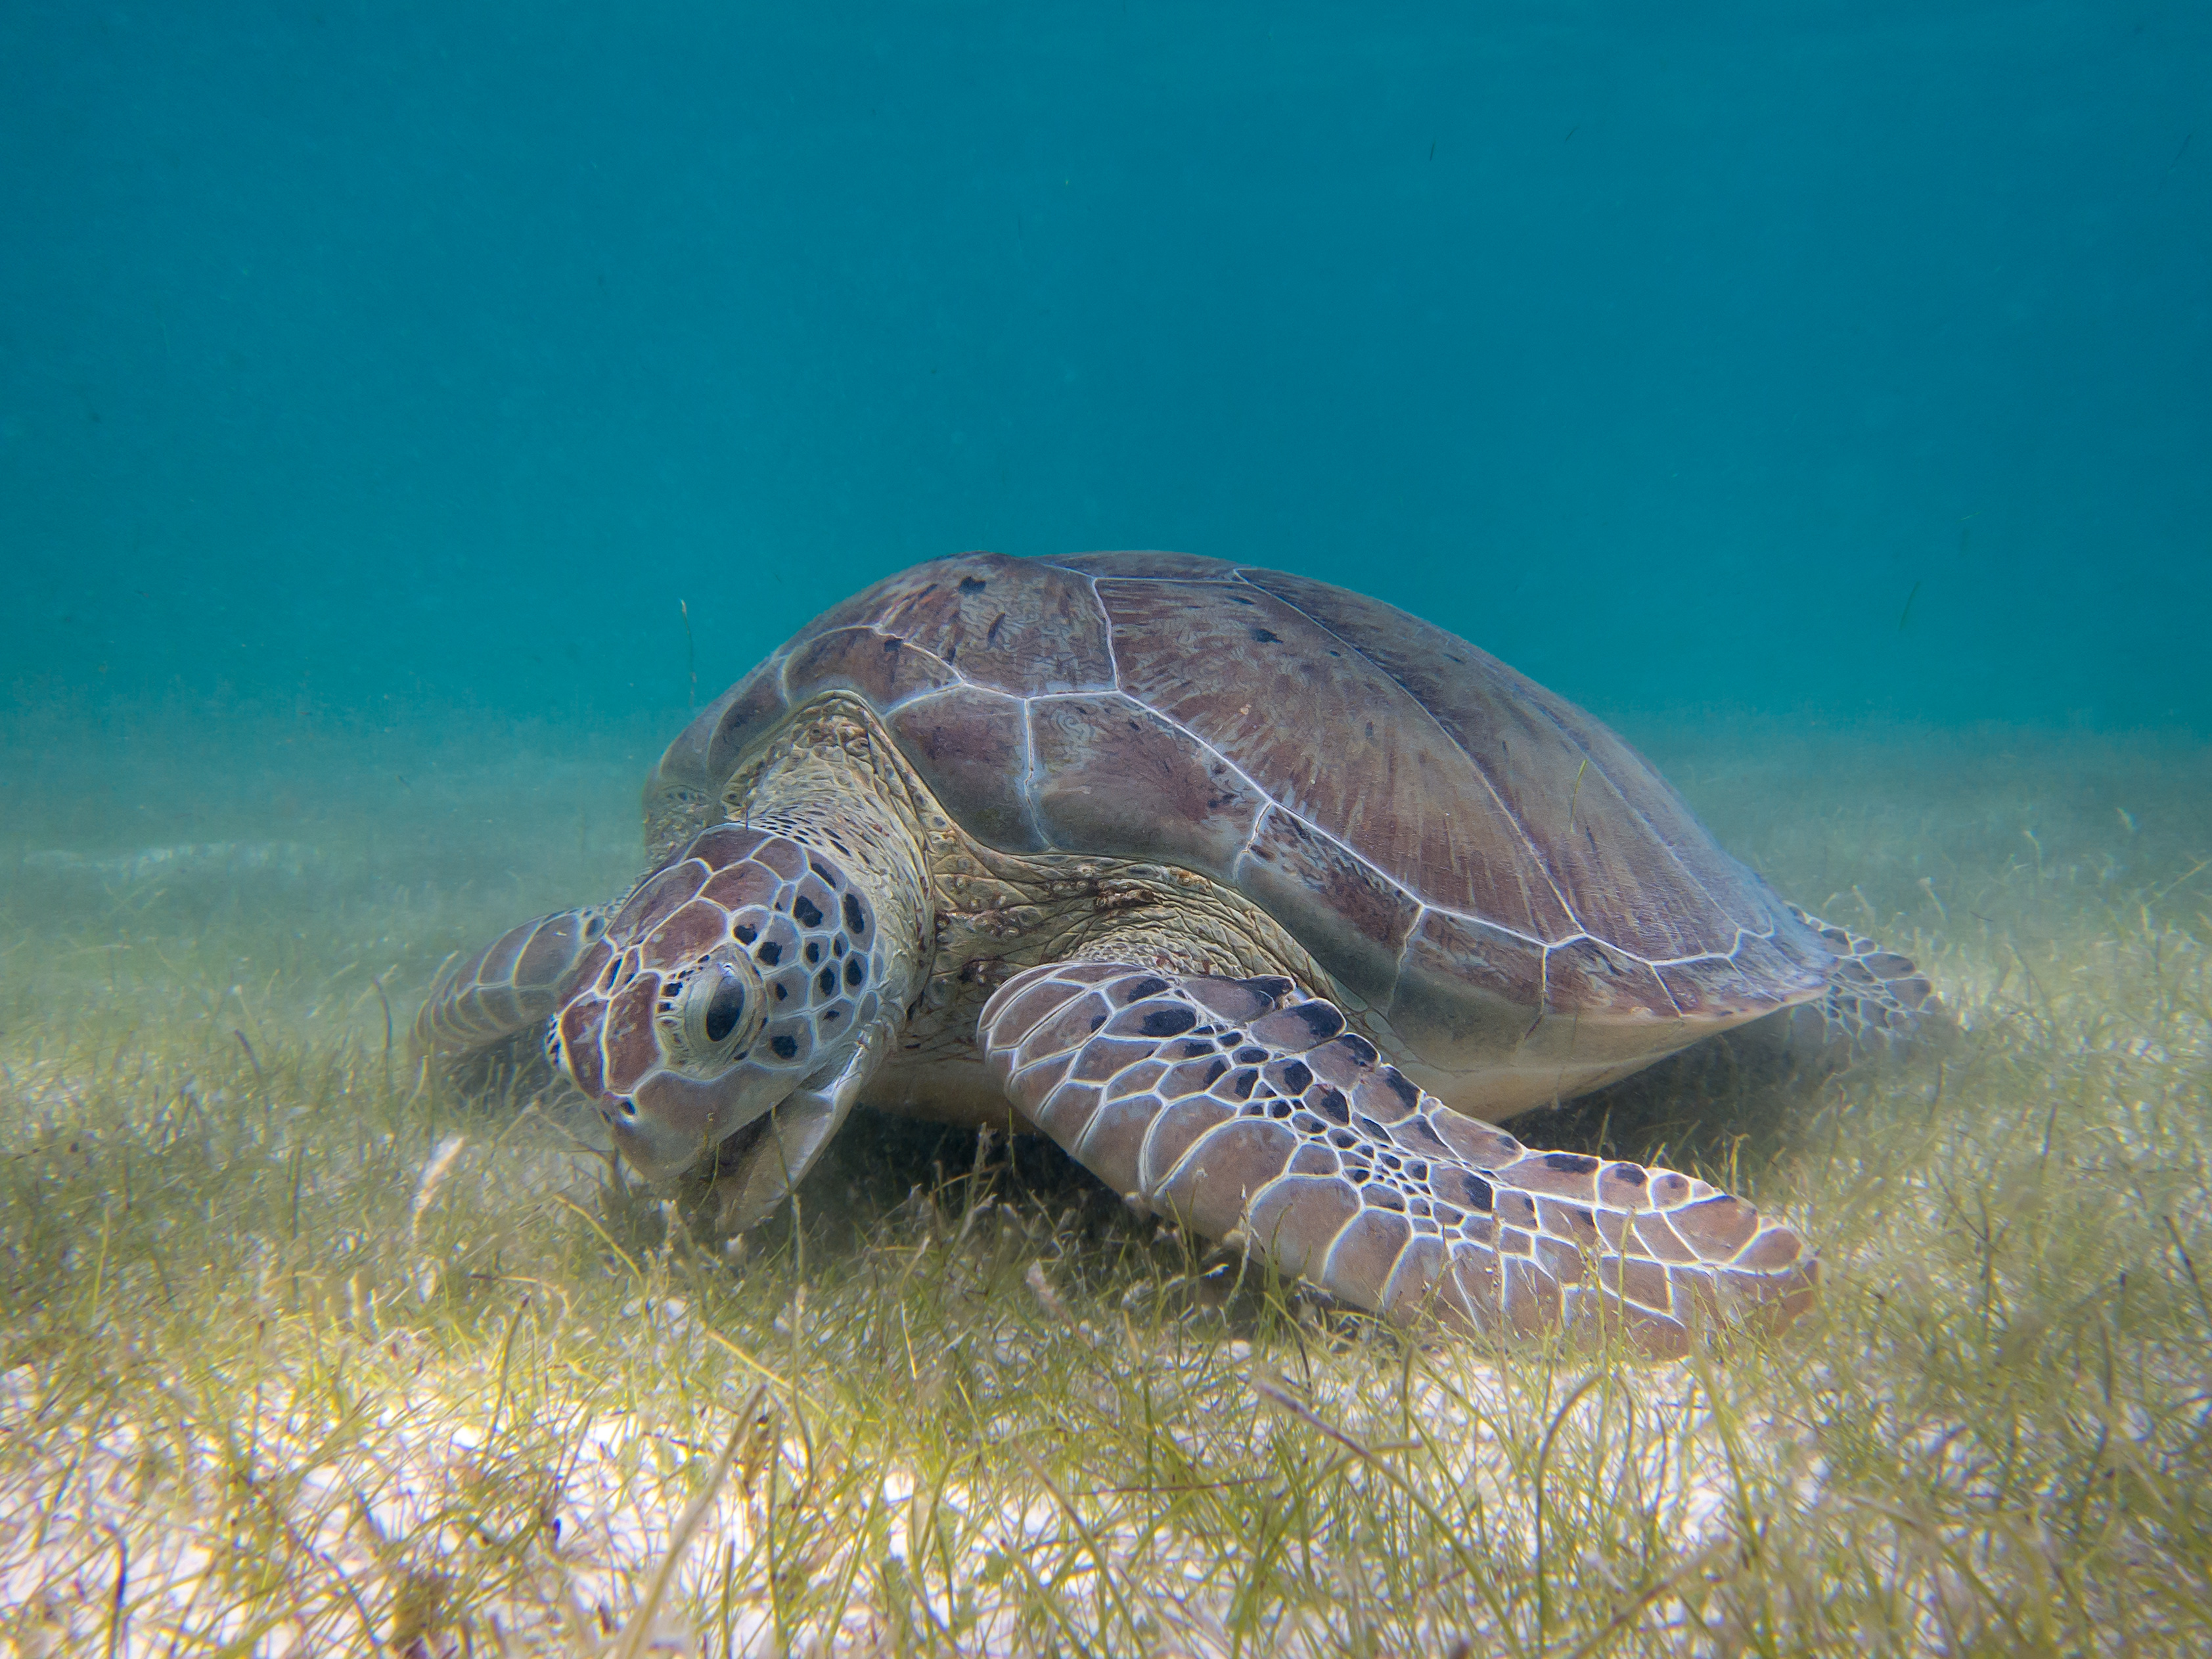

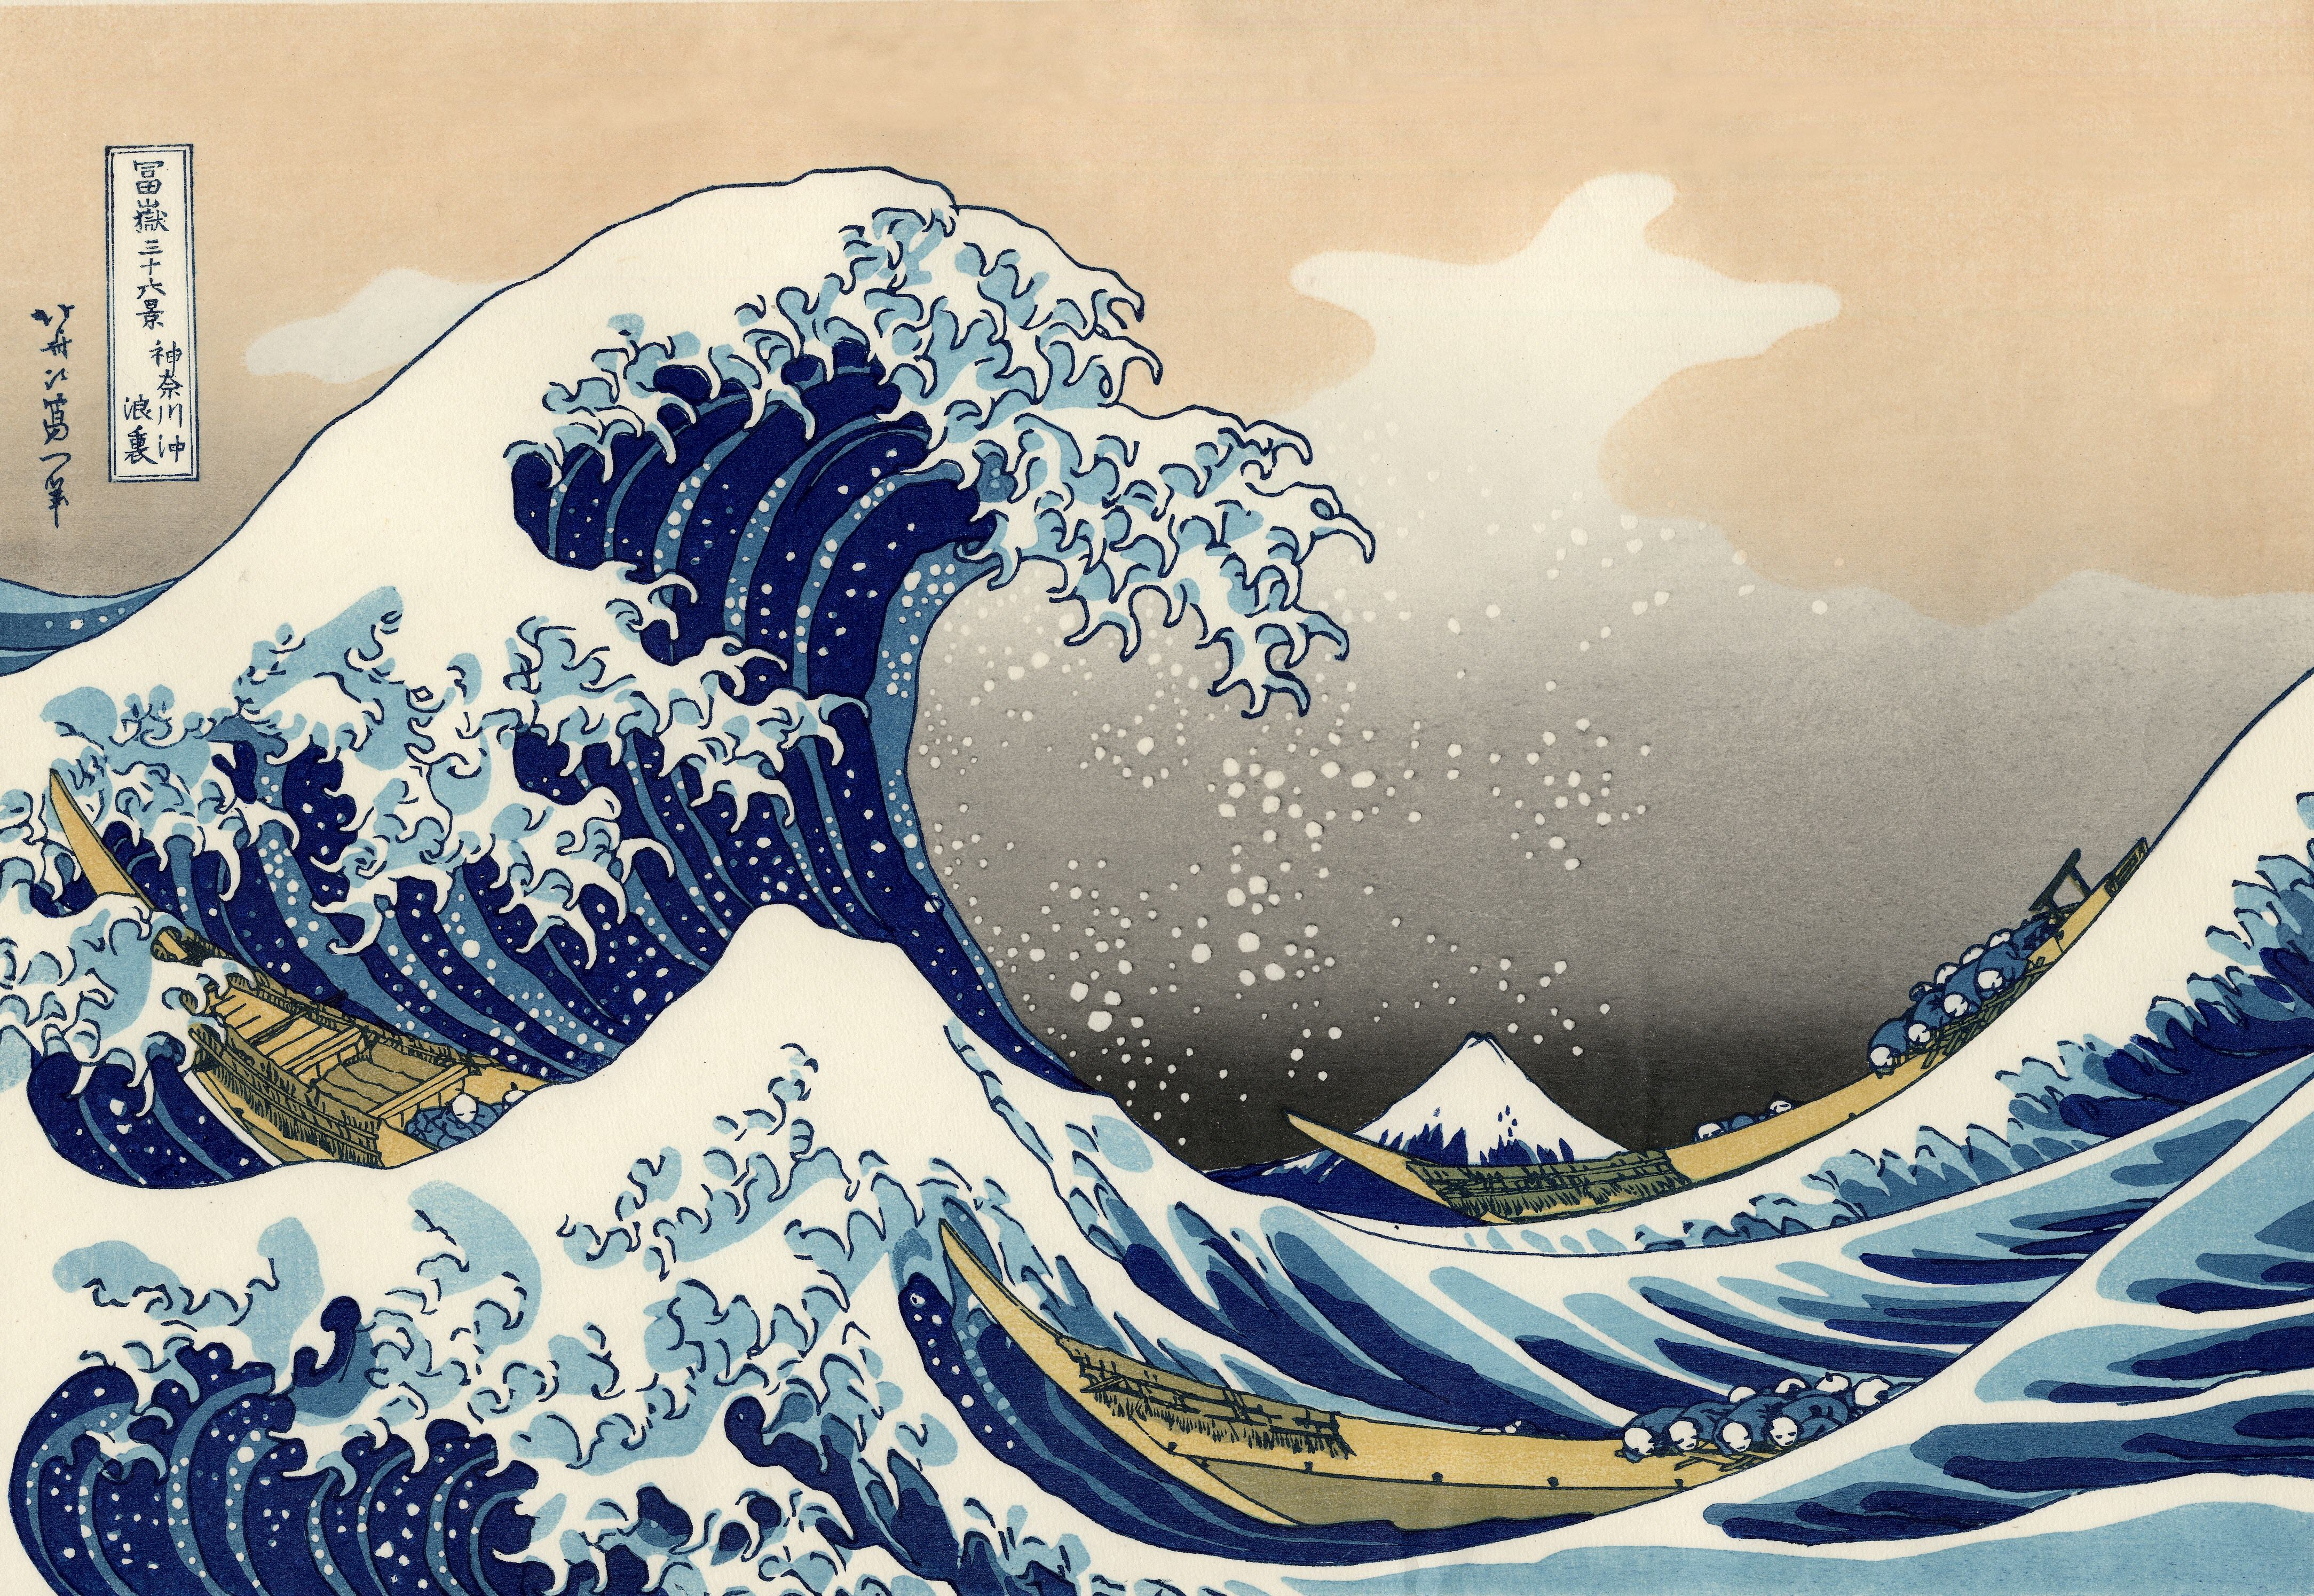

In [ ]:
from IPython.display import Image, display

display(Image(base_image_path))

display(Image(style_reference_image_path))


<font size=4 color='blue'>
Valores mínimos que tendrán los pesos de estilo, base y total.

In [ ]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

<font size=5 color='blue'>
Funciones para pre-procesar y operar las imágenes

In [ ]:
# Función que abre una imágen, cambia su tamaño y la convierte en un tensor de Tensorflow apropiado.
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


# Función que convierte un tensor en una imagen apropiada.
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Elimina el centrado en cero mediante el promedio del valor del pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


<font size=4 color='black'>
    
Sobre el método: [np.clip()](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)<br/>
Sobre el método: [keras.preprocessing.image()](https://keras.io/api/preprocessing/image/)<br/>
Sobre el método: [np.expand_dims()](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html)

<font size=5 color='blue'>
Arquitectura del modelo para extractor los rasgos

<font size=4 color='black'>
    
Se mportan los pesos de la arquitectura VGG-19 pre-entrenada con la base ImageNet

In [ ]:
model = vgg19.VGG19(weights="imagenet", include_top=False)

<font size=4 color='black'>
    
Sobre el método: [tf.keras.applications.VGG19](https://keras.io/api/applications/)

<font size=4 color='black'>
Capas de convolución en la arquitectura

In [ ]:
model.layers
#This model contains 16 convolutional layers

<font size=4 color='black'>
Se genera un diccionario con el nombre y tipo de cada capa

In [ ]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

<font size=5 color='blue'>
Implementación del modelo

In [ ]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

<font size=4 color='black'>
    
Sobre el método: [tf.keras.Model()](https://keras.io/api/models/model/)

<font size=5 color='blue'>
    
Función de costo 

<font size=4 color='black'>
    
Se definen las siguientes funciones:

<ul>
    <li>1.- Gram_matrix
        <ul>
            <li> Producto entre tensores.
        </ul>
    <li>2.- Función de Costo para el estilo
        <ul>
            <li>Mantiene la imagen generada cercana a la textura de la imagen de referencia de estilo.
        </ul>
    <li>3.- Función de Costo para el contenido
        <ul>
            <li>Mantiene la representación de alto nivel de la imagen generada cercana a la de la imagen de base.
        </ul>
    <li>4.- Función de Costo total
        <ul>
            <li>Función que proporciona coherencia local a la imagen generada.
        </ul>
</ul>

In [ ]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


Sobre el método: [tf.reduce_sum()](https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/math/reduce_sum)
Sobre el método: [tf.pow()](https://www.tensorflow.org/versions/r2.3/api_docs/python/tf/math/pow)
Sobre el método: [tf.matmul()](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul)

<font size=4 color='black'>
    
Se define la función "compute_loss()" para calcular costo en las imágenes: estilo, contenido y combiación.

In [ ]:
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Inicializamos el costo como un arreglo de ceros
    loss = tf.zeros(shape=())

    # Costo de contenido
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    
    # Costo de estilo
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Costo total
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


<font size=5 color='blue'>
    
Optimización

<font size=4 color='black'>
Se utilizará el método de gradiente descendente

In [ ]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

Sobre el método: [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)

<font size=4 color='black'>
    
*** Ell parámetro tasa de aprendizaje (learning rate) se reduce en 0.96 cada 100 épocas ***

In [ ]:
initial_learning_rate = 100.0
decay_steps = 100
decay_rate = 0.96

optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
                                initial_learning_rate = initial_learning_rate, 
                                decay_steps = decay_steps, 
                                decay_rate = decay_rate))

<font size=5 color='blue'>
    
Implementación del sistema de aprendizaje

<font size=4 color='black'>
Definición de las capas ocultas con las que se calcularán los costos.

In [ ]:
#Lista de las capas a utilizar para la determinación del costo referente al estilo.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

# Lista con la capa a utilizar en la determinación del costo referente al contenido de la imagen original.
content_layer_name = "block5_conv2"

<font size=4 color='black'>
Adecuación de las imágenes 

In [ ]:
base_image = preprocess_image(base_image_path)

style_reference_image = preprocess_image(style_reference_image_path)

combination_image = tf.Variable(preprocess_image(base_image_path))

Sobre el método: [tf.Variable()](https://www.tensorflow.org/api_docs/python/tf/Variable)

<font size=5 color='blue'>
    
Transfiriendo el estilo

In [ ]:
epochs = 1000

for i in range(1, epochs + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    
    optimizer.apply_gradients([(grads, combination_image)])
    
    if i % 100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        
img = deprocess_image(combination_image.numpy())
fname= "final_image.png"
keras.preprocessing.image.save_img(fname,img)

Iteration 100: loss=10596.72
Iteration 200: loss=8636.46
Iteration 300: loss=7851.86
Iteration 400: loss=7408.77
Iteration 500: loss=7112.69
Iteration 600: loss=6895.80
Iteration 700: loss=6728.26
Iteration 800: loss=6594.18
Iteration 900: loss=6483.55
Iteration 1000: loss=6390.86


<font size=5 color='blue'>
Imagen transformada

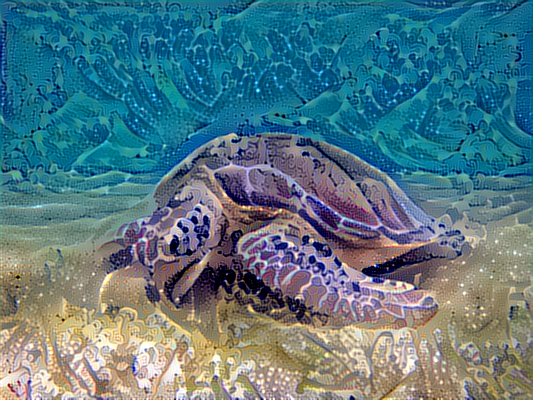

In [ ]:
display(Image(fname))
